# Topic Model and Correlation

In [95]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

from wordcloud import WordCloud
plt.style.use('seaborn-darkgrid')
%matplotlib inline

In [96]:
#load datset
fname = 'data2.txt'
articles = []
errs = 0
with open(fname, 'r') as f:
    art = []
    while True:
        line = f.readline()
        if not line:
            break
        if 'URL' in line:
            if art != []:
                paper = ' '.join(art)
                if 'No corrections appeared in print' not in paper: #error papers
                    articles.append(paper)
                else:
                    errs += 1
            art = []
        elif line not in {'\n', ' '}:
            art.append(line.rstrip('\n'))

In [97]:
print(len(articles), errs)

98 0


In [98]:
class Vocab(TfidfVectorizer):
    def __init__(self, texts, **kwargs):
        super(Vocab, self).__init__(**kwargs)
        self.fit(texts)

    def __len__(self):
        return len(self.vocabulary_)
    
    def _to_bow(self, sent):
        prep = self.build_preprocessor()
        analyzer = self.build_analyzer()
        seq = analyzer(prep(sent))
        return [w for w in seq if w in self.vocabulary_]

    def _to_indices(self, sent):
        return [self.vocabulary_[w] for w in self._to_bow(sent)]


def save_model(model, filename):
    print('saving model to %s ...' % filename)
    pickle.dump(model, open(filename, 'wb'))

def load_model(filename):
    print('loading model from %s ...' % filename)
    return pickle.load(open(filename, 'rb'))

In [99]:
nlp = spacy.load('en_core_web_sm')
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    def __call__(self, doc):
        return [t.lemma_ for t in self.wnl(doc)]

In [100]:
vocab_size = 15000

kwargs = {'stop_words': 'english', 'max_df': 0.5, 'min_df': 3, 'ngram_range': (1, 1),
            'max_features': vocab_size, 'strip_accents': 'unicode'}
try:
    vocab = load_model('vocab.mode')
except:
    print('... creating new model')
    vocab = Vocab(articles, tokenizer=LemmaTokenizer(), **kwargs)

loading model from vocab.mode ...
... creating new model


In [101]:
print(len(vocab))
save_model(vocab, 'model/vocab.mod')

376
saving model to model/vocab.mod ...


In [102]:
text = 'mr. trump and colleagues\n^ are going to do something about it. Australia is highly concerned.'
print(vocab._to_bow(text))

[]


## Topic extraction

In [103]:
import pyLDAvis
pyLDAvis.enable_notebook()
import gensim

In [104]:
arts_in_bow = [vocab._to_bow(art) for art in articles]
dct = gensim.corpora.Dictionary(arts_in_bow)
corpus = [dct.doc2bow(a) for a in arts_in_bow]

In [105]:
num_topics = 20
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dct, passes=5, 
                                           alpha=[0.01]*num_topics, eta=[0.01]*len(dct.keys()))
if not os.path.exists('model'):
    os.makedirs('model')
ldamodel.save('model/lda.gensim')
topics = ldamodel.print_topics(num_words=30)
for topic in topics:
    print(topic)

(0, '0.017*"3d" + 0.017*"journey" + 0.016*"american" + 0.014*")" + 0.014*"earth" + 0.014*"star" + 0.014*"(" + 0.013*"2008" + 0.013*"adaptation" + 0.013*"center" + 0.010*"bob" + 0.010*"chris" + 0.010*"ensemble" + 0.010*"chalamet" + 0.010*"amy" + 0.010*"timotha" + 0.009*"eliza" + 0.009*"emma" + 0.009*"louisa" + 0.009*"greta" + 0.009*"massachusetts" + 0.009*"\'s" + 0.009*"come" + 0.009*"watson" + 0.009*"laura" + 0.009*"cooper" + 0.009*"seventh" + 0.009*"dern" + 0.009*"saoirse" + 0.009*"letts"')
(1, '0.017*"write" + 0.017*"2019" + 0.017*"star" + 0.017*"emma" + 0.017*"march" + 0.017*"drama" + 0.017*"watson" + 0.017*"american" + 0.017*"adaptation" + 0.017*"cast" + 0.017*"odenkirk" + 0.017*"life" + 0.017*"meg" + 0.017*"pugh" + 0.017*"streep" + 0.017*"age" + 0.017*"meryl" + 0.017*"century" + 0.017*"alcott" + 0.017*"james" + 0.017*"betha€”in" + 0.017*"little" + 0.017*"concord" + 0.017*"1868" + 0.017*"19th" + 0.017*"e" + 0.017*"louis" + 0.017*"gerwig" + 0.017*"garrel" + 0.017*"comprise"')
(2, '0

In [106]:
ldamodel.get_document_topics(dct.doc2bow(vocab._to_bow(articles[0])))

[(17, 0.9940994)]

In [107]:
ldamodel.state.get_lambda().shape

(20, 376)

In [108]:
ldamodel.num_terms

376

In [109]:
def get_topics(lda, num_words=30):
    l_topics = []
    for i in range(lda.num_topics):
        topic = ldamodel.state.get_lambda()[i]
        topic = topic / np.sum(topic)
        mx_indices = sorted(range(lda.num_terms), key=lambda a: topic[a], reverse=True)[:num_words]
        words = [lda.id2word[j] for j in mx_indices]
        l_topics.append(words)
    return l_topics

In [110]:
print(get_topics(ldamodel))

[['3d', 'journey', 'american', ')', 'earth', 'star', '(', '2008', 'adaptation', 'center', 'bob', 'chris', 'ensemble', 'chalamet', 'amy', 'timotha', 'eliza', 'emma', 'louisa', 'greta', 'massachusetts', "'s", 'come', 'watson', 'laura', 'cooper', 'seventh', 'dern', 'saoirse', 'letts'], ['write', '2019', 'star', 'emma', 'march', 'drama', 'watson', 'american', 'adaptation', 'cast', 'odenkirk', 'life', 'meg', 'pugh', 'streep', 'age', 'meryl', 'century', 'alcott', 'james', 'betha€”in', 'little', 'concord', '1868', '19th', 'e', 'louis', 'gerwig', 'garrel', 'comprise'], [')', '(', 'sean', 'r.', 'ring', 'rhys', 'production', 'viggo', 'fantasy', 'cate', 'international', 'united', 'bloom', 'john', 'new', 'tolkien', 'wingnut', 'series', 'tyler', 'monaghan', 'boyd', 'epic', '2003', 'adventure', 'line', 'dominic', 'bean', 'davy', '2002', 'ensemble'], ['2019', 'patient', ')', 'play', 'american', ']', '(', 'force', 'romantic', 'elgort', 'drama', 'cancer', 'cystic', 'claire', 'distance', 'lionsgate.[1',

In [111]:
probs = ldamodel.state.get_lambda()
probs = probs / np.sum(probs, axis=1, keepdims=True)

In [112]:
np.sum(probs[0])

0.99999994

In [113]:
from numpy.linalg import norm

N = norm(probs, axis=1)
heatmap = (probs @ probs.T) / np.einsum('i, j->ij', N, N)

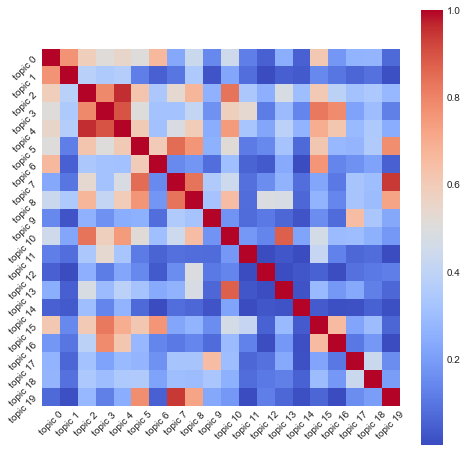

In [114]:
plt.figure(figsize=(8,8))
plt.imshow(heatmap, cmap='coolwarm')
plt.grid(None)
ticks = list(map(lambda a: 'topic %d' % a, range(ldamodel.num_topics)))
plt.xticks(np.arange(ldamodel.num_topics), ticks, rotation=45)
plt.yticks(np.arange(ldamodel.num_topics), ticks, rotation=45)
plt.colorbar()
plt.show()

In [115]:
from wordcloud import WordCloud

In [116]:
def vis_topic(topic, save_fname=None, **kwargs):
    wordcloud = WordCloud(**kwargs).generate(' '.join(topic))
    if save_fname is not None:
        wordcloud.to_file(save_fname)
    return wordcloud
num_topics = ldamodel.num_topics
w = h = 200
import cv2 as cv
mask = cv.imread('img/circle.jpg')
wcargs = {'width': w, 'height': h, 'background_color': "rgba(255, 255, 255, 0)", 'mode': "RGBA",
        'max_font_size': 100, 'min_font_size': 10, 'colormap': 'Paired', 'mask': mask}

In [117]:
topics = get_topics(ldamodel)
print(topics[0])

['3d', 'journey', 'american', ')', 'earth', 'star', '(', '2008', 'adaptation', 'center', 'bob', 'chris', 'ensemble', 'chalamet', 'amy', 'timotha', 'eliza', 'emma', 'louisa', 'greta', 'massachusetts', "'s", 'come', 'watson', 'laura', 'cooper', 'seventh', 'dern', 'saoirse', 'letts']


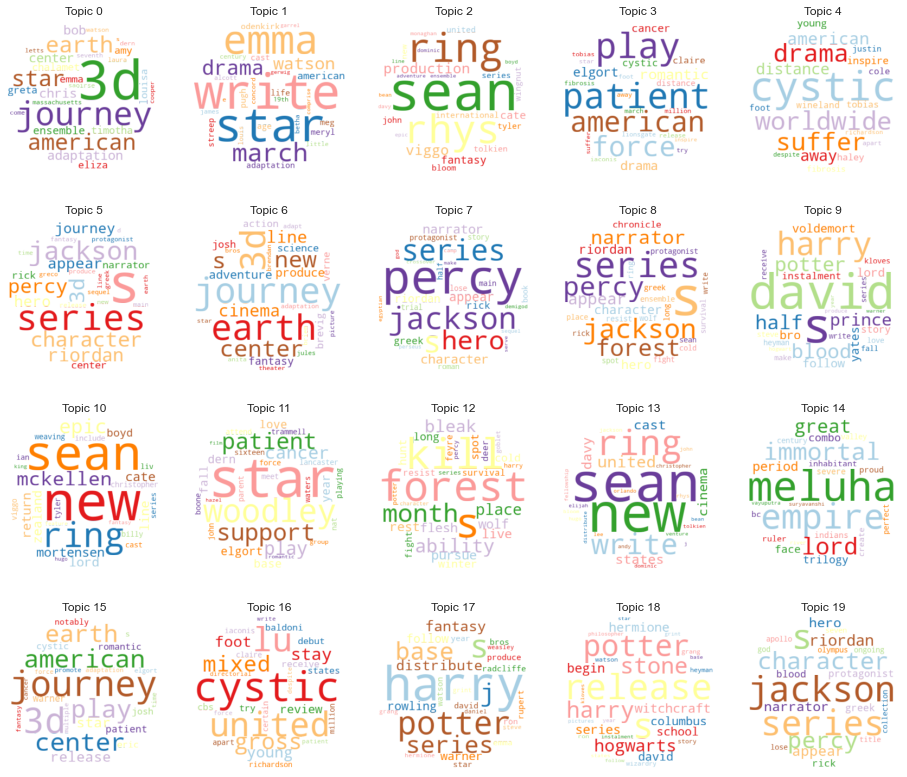

In [118]:
fig, axes = plt.subplots(num_topics // 5, 5, figsize=(16, 14))
for i in range(num_topics):
    r, c = i // 5, i % 5
    
    wordcloud = vis_topic(topics[i], **wcargs)
    axes[r, c].imshow(wordcloud, interpolation="bilinear")
    axes[r, c].axis("off")
    axes[r, c].set_title('Topic %d' % i)

wordcloud.to_file('wordcloud.png')
plt.show()

In [119]:
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

topic_clouds = [vis_topic(topic, **wcargs).to_array() for topic in topics]
coords = np.random.randint(num_topics // 2, size=(num_topics, 2))
print(topic_clouds[0].shape)

(283, 284, 4)


In [120]:
def draw_line(ax, p1, p2, linewidth, color='black'):
    ax.annotate(p2,
                xy=p2, xycoords='data',
                xytext=p1, size=20, va="center", ha="center",
                arrowprops=dict(arrowstyle="<|-|>",
                                connectionstyle="arc3,rad=-0.2",
                                fc="w", linewidth=linewidth, color=color))

def im_annot(im_array, coords, zoom=0.5):
    imagebox = OffsetImage(im_array, interpolation='bilinear', zoom=zoom)
    annot = AnnotationBbox(imagebox, coords, 
                        bboxprops=dict(facecolor='none', edgecolor='none', boxstyle='round'),
                      )
    return annot

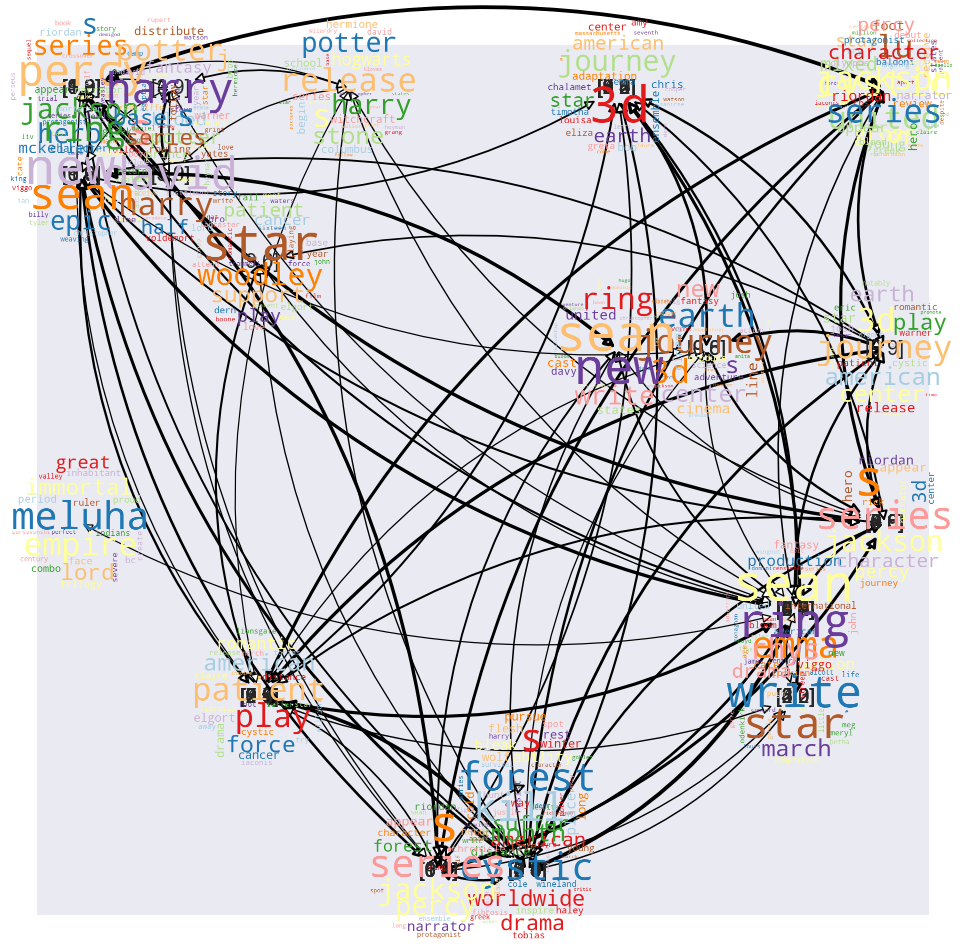

In [121]:
zoom = 1
margin = zoom // 2
lim = np.max(coords, axis=0)

fig, ax = plt.subplots(figsize=(16, 16))

ax.set_xlim(-0.5, lim[0] + 0.5)
ax.set_ylim(-0.5, lim[1] + 0.5)

for i, topic in enumerate(topic_clouds):
    ax.add_artist(im_annot(topic, coords[i]))
    for j in range(num_topics):
        if i >= j:
            continue
        link = heatmap[i, j]
        if link >= 0.3:
            draw_line(ax, coords[i], coords[j], link * 4)
    
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.grid(None)

#plt.draw()
plt.show()

In [122]:
def read_corpus(corpus, tokens_only=False):
    for i, line in enumerate(corpus):
        if tokens_only:
            yield line # use this func to tokenize a line
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(line, [i])

In [123]:
data = list(read_corpus(arts_in_bow))

In [124]:
data[0]

TaggedDocument(words=['harry', 'potter', 'series', 'base', 'j.', 'k.', 'rowling', 'series', 'distribute', 'warner', 'bros', 'fantasy', 'begin', 'harry', 'potter', 'philosopher', "'s", 'stone', '(', '2001', ')', 'harry', 'potter', 'a€', '"', '(', ']', 'series', '(', ')', 'mark', ']'], tags=[0])

Now how we retrieve topics from unseen document?

In [129]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=40)
model.build_vocab(data)
%time model.train(data, total_examples=model.corpus_count, epochs=model.epochs)

Wall time: 392 ms


In [130]:
def sort_relevant(subj, model, data, vocab, topn=5):
    s = vocab._to_bow(subj)
    rep = model.infer_vector(s)
    print(s)
    sims = model.docvecs.most_similar([rep], topn=topn)
    return sims

In [132]:
your_question = 'Harry Potter'
print('Your question is: %s' %your_question)

sims = sort_relevant(your_question, model, data, vocab, 10)
for i, perti in enumerate(sims):

    print(u'TOP %s RELEVANT %s: «%s»\n' % (i, perti, articles[perti[0]]))

Your question is: Harry Potter
['harry', 'potter']
TOP 0 RELEVANT (45, 0.92229825258255): «Harry Potter and the Goblet of Fire is a 2005 fantasy film directed by Mike Newell and distributed by Warner Bros. Pictures, based on J. K. Rowling's 2000 novel of the same name. Produced by David Heyman and written by Steve Kloves, it is the sequel to Harry Potter and the Prisoner of Azkaban (2004) and the fourth instalment in the Harry Potter film series. The film stars Daniel Radcliffe as Harry Potter, with Rupert Grint as Ron Weasley, and Emma Watson as Hermione Granger. Its story follows Harry's fourth year at Hogwarts as he is chosen by the Goblet of Fire to compete in the Triwizard Tournament. »

TOP 1 RELEVANT (36, 0.9201635718345642): «Harry Potter and the Goblet of Fire is a 2005 fantasy film directed by Mike Newell and distributed by Warner Bros. Pictures, based on J. K. Rowling's 2000 novel of the same name. Produced by David Heyman and written by Steve Kloves, it is the sequel to Har